In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

## IGNORING THE PANDAS WARNINGS

In [2]:
from warnings import simplefilter

simplefilter(action = 'ignore', category = Warning)

## IMPORTING THE DATA

In [3]:
def import_data(path):
    data = pd.read_csv(path).drop('Unnamed: 0', axis = 1)
    return data

sales = import_data('data/sales.csv')

## LOOKING AT THE COLUMNS

In [4]:
sales.head(10)

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,366,4,2013-04-18,517,1,0,0,0,4422
1,394,6,2015-04-11,694,1,0,0,0,8297
2,807,4,2013-08-29,970,1,1,0,0,9729
3,802,2,2013-05-28,473,1,1,0,0,6513
4,726,4,2013-10-10,1068,1,1,0,0,10882
5,674,2,2013-03-19,1016,1,1,0,0,8406
6,659,7,2014-06-08,0,0,0,0,0,0
7,27,3,2014-07-16,1106,1,1,0,1,11162
8,347,6,2013-05-11,448,1,0,0,0,5559
9,288,2,2013-06-25,291,1,0,0,0,3997


## CONVERTING THE DATE COLUMN INTO DATETIME FORMAT AND EXTRACTING THE DAY, THE MONTH AND THE YEAR

In [5]:
def to_datetime(dataframe, column):

    dataframe[column] = pd.to_datetime(dataframe[column])

    dataframe['year'] = dataframe[column].dt.year
    dataframe['month'] = dataframe[column].dt.month
    dataframe['day'] = dataframe[column].dt.day
    
    dataframe = dataframe.drop(column, axis = 1)

    return dataframe

sales = to_datetime(sales, 'date')

## REPLACING THE A, B AND C VALUES FROM THE STATE HOLIDAY COLUMN WITH THE 1 VALUE

In [6]:
def reduce_state_holiday(x):

    if x == 'a':
        return 1

    elif x == 'b':
        return 1

    elif x == 'c':
        return 1

    else:
        return int(x)

sales['state_holiday'] = sales['state_holiday'].apply(reduce_state_holiday)

## ENCODING THE DAY OF WEEK COLUMN USING ONE HOT ENCODER

In [7]:
def encode_week_day(dataframe, column):

    dataframe[column] = dataframe[column].astype('category')
    encoder = OneHotEncoder().fit(dataframe[[column]])
    encoded_column = encoder.transform(dataframe[[column]]).toarray()
    encoded_dataframe = pd.DataFrame(data = encoded_column, columns = list(encoder.categories_))
    dataframe = pd.concat([dataframe, encoded_dataframe], axis = 1)
    dataframe = dataframe.drop(column, axis = 1)

    return dataframe, encoder

sales, encoder = encode_week_day(sales, 'day_of_week')


## CORRELATION MATRIX BETWEEN ALL THE VARIABLES AND THE TARGET

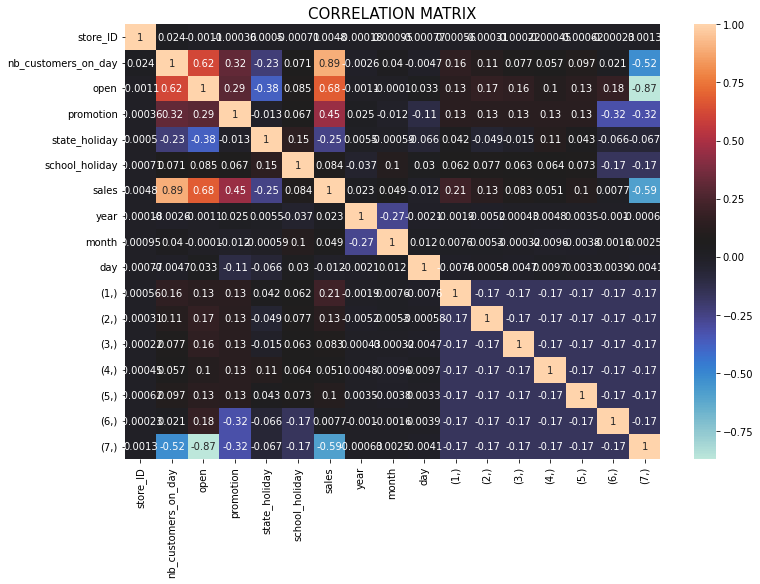

In [8]:
fig = plt.figure(figsize = (12, 8))
sns.heatmap(sales.corr(), annot = True, cmap = 'icefire')
plt.title('CORRELATION MATRIX', fontsize = 15)
plt.show()

## DROPPING THE STORE ID BECAUSE IS AN IDENTIFIER AND IS GIVING NO INFORMATION

In [9]:
def drop_columns(dataframe, columns):
    return dataframe.drop(columns, axis = 1)

sales = drop_columns(sales, ['store_ID', 'day', 'month', 'year', 
                             'school_holiday', (3,), (4,), (6,)])

## PERFORMING THE X-Y TRAIN-TEST SPLIT IN THE SALES DATAFRAME

In [10]:
X = sales.drop('sales', axis = 1)
y = sales['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 100)

## SCALING THE DATA WITH THE STANDARD SCALER

In [11]:
def scale_data(training, testing, columns):

    scaler = StandardScaler().fit(training[columns])
    training[columns] = scaler.transform(training[columns])
    testing[columns] = scaler.transform(testing[columns])

    return training, testing, scaler

X_train_scaled, X_test_scaled, scaler = scale_data(X_train, X_test, ['nb_customers_on_day'])

## TRAINING THE STANDARD VERSION OF ALL THE MODELS AND EVALUATING THE PERFORMANCE

In [12]:
def train_models(training_x, training_y, testing_x, testing_y, models):

    models_names = list()
    training_scores = list()
    testing_scores = list()
    rmse_scores_training = list()
    rmse_scores_test = list()

    for model in models:

        model.fit(training_x, training_y)
        predicitons_training = model.predict(training_x)
        predictions_test = model.predict(testing_x)
        models_names.append(type(model).__name__)
        training_scores.append(round(model.score(training_x, training_y), 2))
        testing_scores.append(round(model.score(testing_x, testing_y), 2))
        rmse_scores_training.append(mean_squared_error(training_y, predicitons_training, squared = False))
        rmse_scores_test.append(mean_squared_error(testing_y, predictions_test, squared = False))

    results = pd.DataFrame()

    results['model_name'] = models_names
    results['training_score'] = training_scores
    results['testing_score'] = testing_scores
    results['rmse_training'] = rmse_scores_training
    results['rmse_test'] = rmse_scores_test

    return results

'''
models_results = train_models(X_train_scaled, y_train, X_test_scaled, y_test, 
                             [LinearRegression(), XGBRegressor(), GradientBoostingRegressor(), 
                              CatBoostRegressor(), KNeighborsRegressor()])
'''

'\nmodels_results = train_models(X_train_scaled, y_train, X_test_scaled, y_test, \n                             [LinearRegression(), XGBRegressor(), GradientBoostingRegressor(), \n                              CatBoostRegressor(), KNeighborsRegressor()])\n'

## SHOWING THE PERFORMANCE FOR EVERY CLASSIFIER

In [13]:
# models_results

## CREATING THE GRADIENT BOOSTING FINAL MODEL

In [14]:
GB_model = GradientBoostingRegressor()
GB_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor()

## CREATING THE XGBOOST FINAL MODEL

In [15]:
XGB_model = XGBRegressor()
XGB_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## CREATING THE CATBOOST FINAL MODEL

In [16]:
CAT_model = CatBoostRegressor(verbose = 0)
CAT_model.fit(X_train_scaled, y_train)

## IMPORTING THE NEW DATA FOR THE PREDICTIONS

In [ ]:
sales_to_predict = import_data('data/sales_to_predict.csv')

## PREPROCESSING THE NEW DATA

In [ ]:
sales_to_predict = to_datetime(sales_to_predict, 'date')
sales_to_predict['state_holiday'] = sales_to_predict['state_holiday'].apply(reduce_state_holiday)
week_day_encoded = encoder.transform(sales_to_predict[['day_of_week']]).toarray()
week_day_encoded_df = pd.DataFrame(data = week_day_encoded, columns = list(encoder.categories_))
sales_to_predict = pd.concat([sales_to_predict, week_day_encoded_df], axis = 1)
sales_to_predict = sales_to_predict.drop('day_of_week', axis = 1)
sales_to_predict['nb_customers_on_day'] = scaler.transform(sales_to_predict['nb_customers_on_day'])